# Modeling and Simulation in Python

Starter code for the orbit example

Alex Hindelang

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Earth falling into the sun

Here's a question from the web site [Ask an Astronomer](http://curious.astro.cornell.edu/about-us/39-our-solar-system/the-earth/other-catastrophes/57-how-long-would-it-take-the-earth-to-fall-into-the-sun-intermediate):

"If the Earth suddenly stopped orbiting the Sun, I know eventually it would be pulled in by the Sun's gravity and hit it. How long would it take the Earth to hit the Sun? I imagine it would go slowly at first and then pick up speed."

Here's a solution.

In [2]:
# And an inition condition (with everything in SI units)

r_0 = 147e9

init = State(x = r_0, y = 0, vx = 0, vy = -10)

,values
x,1.470000e+11
y,0.000000e+00
vx,0.000000e+00
vy,-1.000000e+01


In [3]:
# Making a system object

r_earth = 6.371e6
r_sun = 695.508e6

system = System(init=init,
                G=6.674e-11,
                m1=1.989e30,
                r_final=r_sun + r_earth,
                m2=5.972e24,
                t_0=0,
                t_end=10e10
               )

,values
init,x 1.470000e+11 y 0.000000e+00 vx 0....
G,6.674e-11
m1,1.989e+30
r_final,7.01879e+08
m2,5.972e+24
t_0,0
t_end,1e+11


In [4]:
# Here's a function that computes the force of gravity

def universal_gravitation(state, system):
    """Computes gravitational force.
    
    state: State object with distance r
    system: System object with m1, m2, and G
    """
    x, y, vx, vy = state
    unpack(system)
    
    r = Vector(x,y)
    force = G * m1 * m2 / r.mag**2
    a, b = pol2cart(-r.angle, force)
    return Vector(a, b)

In [5]:
universal_gravitation(init, system)

<Quantity([ 3.6686486e+22 -0.0000000e+00], 'dimensionless')>

In [6]:
# The slope function

def slope_func(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object containing `g`
    
    returns: derivatives of y and v
    """
    x, y, vx, vy = state
    unpack(system)    

    force = universal_gravitation(state, system)
    dxdt = vx
    dydt = vy
    dvxdt = -force[0] / m2
    dvydt = force[1] / m2
    
    return dxdt, dydt, dvxdt, dvydt

In [7]:
# Always test the slope function!

slope_func(init, 0, system)

(0.0,
 -10.0,
 <Quantity(-0.006143082049146188, 'dimensionless')>,
 <Quantity(-0.0, 'dimensionless')>)

In [8]:
# Here's an event function that stops the simulation
# before the collision

def event_func(state, t, system):
    x, y, vx, vy = state
    r = sqrt(x**2+y**2)
    return r - system.r_final

In [9]:
# Always test the event function!

event_func(init, 0, system)

146298121000.0

In [10]:
# Finally we can run the simulation

results, details = run_ode_solver(system, slope_func)
details

,values
sol,None
t_events,[]
nfev,21668
njev,0
nlu,0
status,-1
message,Required step size is less than spacing betwee...
success,False


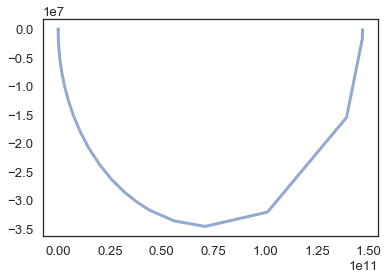

In [11]:
plot(results.x, results.y)

In [12]:
# Here's how long it takes...

t_final = get_last_label(results)

5433399.9950553

In [13]:
# ... expressed in units we understand

t_final = t_final/86400

62.88657401684375

In [14]:
# Before plotting, we run the simulation again with `t_eval`

ts = linspace(t_0, t_final, 201)
results = run_ode_solver(system, slope_func, events=event_func, t_eval=ts)

(                      x           y        vx    vy
 0.000000   1.470000e+11    0.000000  0.000000 -10.0
 0.314433   1.470000e+11   -3.144329 -0.001932 -10.0
 0.628866   1.470000e+11   -6.288657 -0.003863 -10.0
 0.943299   1.470000e+11   -9.432986 -0.005795 -10.0
 1.257731   1.470000e+11  -12.577315 -0.007726 -10.0
 1.572164   1.470000e+11  -15.721644 -0.009658 -10.0
 1.886597   1.470000e+11  -18.865972 -0.011590 -10.0
 2.201030   1.470000e+11  -22.010301 -0.013521 -10.0
 2.515463   1.470000e+11  -25.154630 -0.015453 -10.0
 2.829896   1.470000e+11  -28.298958 -0.017384 -10.0
 3.144329   1.470000e+11  -31.443287 -0.019316 -10.0
 3.458762   1.470000e+11  -34.587616 -0.021247 -10.0
 3.773194   1.470000e+11  -37.731944 -0.023179 -10.0
 4.087627   1.470000e+11  -40.876273 -0.025111 -10.0
 4.402060   1.470000e+11  -44.020602 -0.027042 -10.0
 4.716493   1.470000e+11  -47.164931 -0.028974 -10.0
 5.030926   1.470000e+11  -50.309259 -0.030905 -10.0
 5.345359   1.470000e+11  -53.453588 -0.032837

In [16]:
# Scaling the time steps to days

results.index = results.index * 60 * 60 * 24

TypeError: unsupported operand type(s) for *: 'builtin_function_or_method' and 'int'

In [17]:
# Scaling the distance to million km

r = results.r / 1e9;

AttributeError: 'tuple' object has no attribute 'r'

In [ ]:
# And plotting

plot(r, label='r')

decorate(xlabel='Time (day)',
         ylabel='Distance from sun (million km)')

In [18]:
#these last bits I had some trouble with, but most of it seems okay? I can talk through the last issues with a NINJA but I feel okay about most